In [1]:
from sotip import *
import numpy as np
import scanpy as sc


In [2]:
adata = sc.read_h5ad('sotip_result/MIBI_p4_cur_20211212.h5ad')

In [3]:
me_array = np.array(adata[:,'H3K27me3'].X)
ac_array = np.array(adata[:,'H3K9ac'].X)
adata_add = ad.AnnData(me_array/ac_array)
adata_add.var_names = ['Me/Ac']
adata_add.obs_names = adata.obs_names
adata = ad.concat([adata,adata_add],axis=1,merge='first')

In [4]:
adata.uns['leiden_EMD_merge_colors'] = ['r','k']

In [5]:
rename_dict = {
    '1':'immune',
    '9':'tumor'
}
adata.obs['leiden_EMD_merge'] = adata.obs['leiden_EMD_merge'].cat.rename_categories(rename_dict)

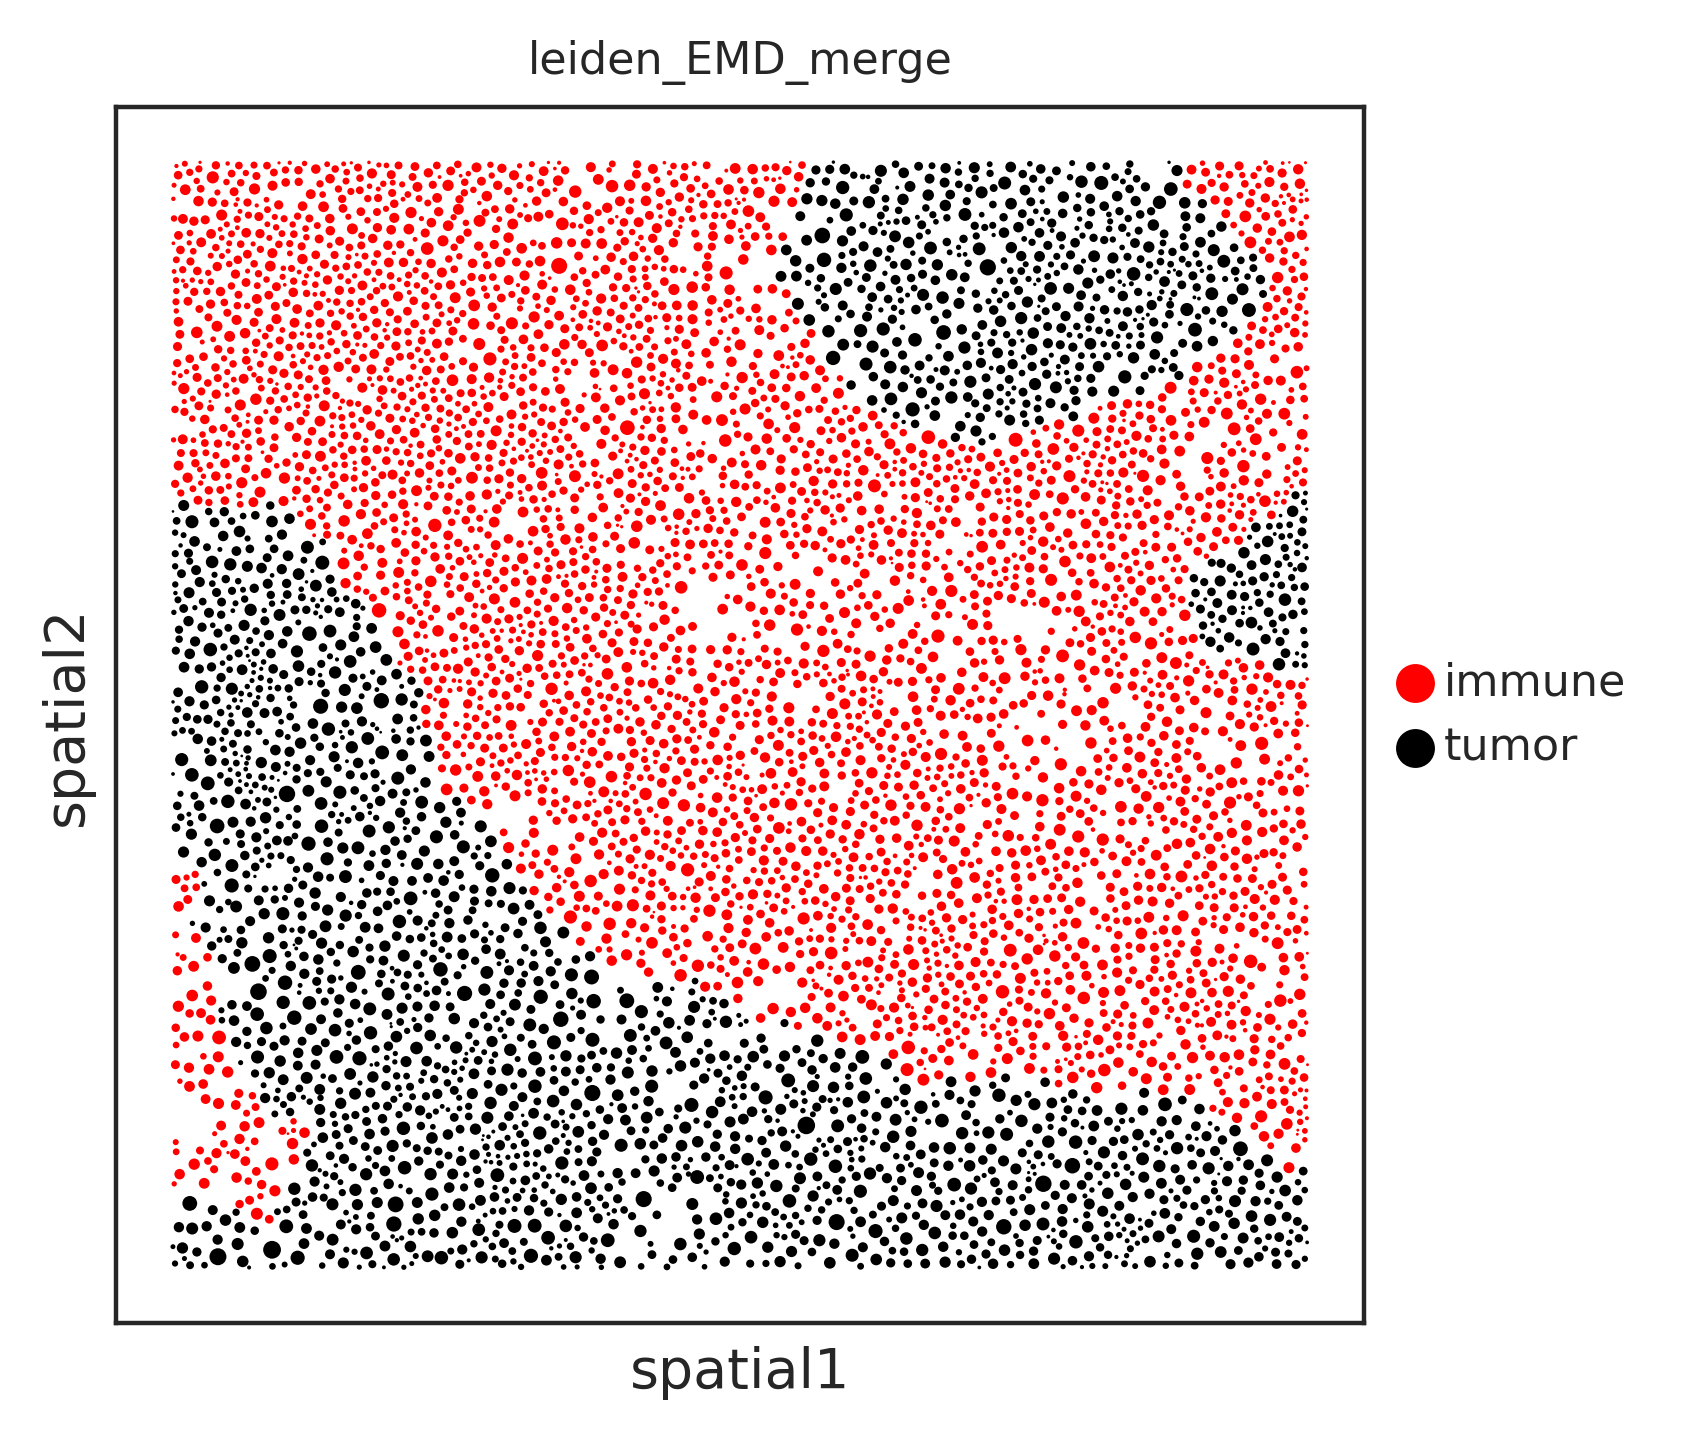

In [6]:
sc.pl.embedding(adata,basis='spatial',color=['leiden_EMD_merge'],size=adata.obs['cellSize']/50)

In [7]:
# 分别计算所有细胞到这两类区域的最短距离
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [8]:
for region in adata.obs['leiden_EMD_merge'].cat.categories:
    cur_idx = np.where(adata.obs['leiden_EMD_merge']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

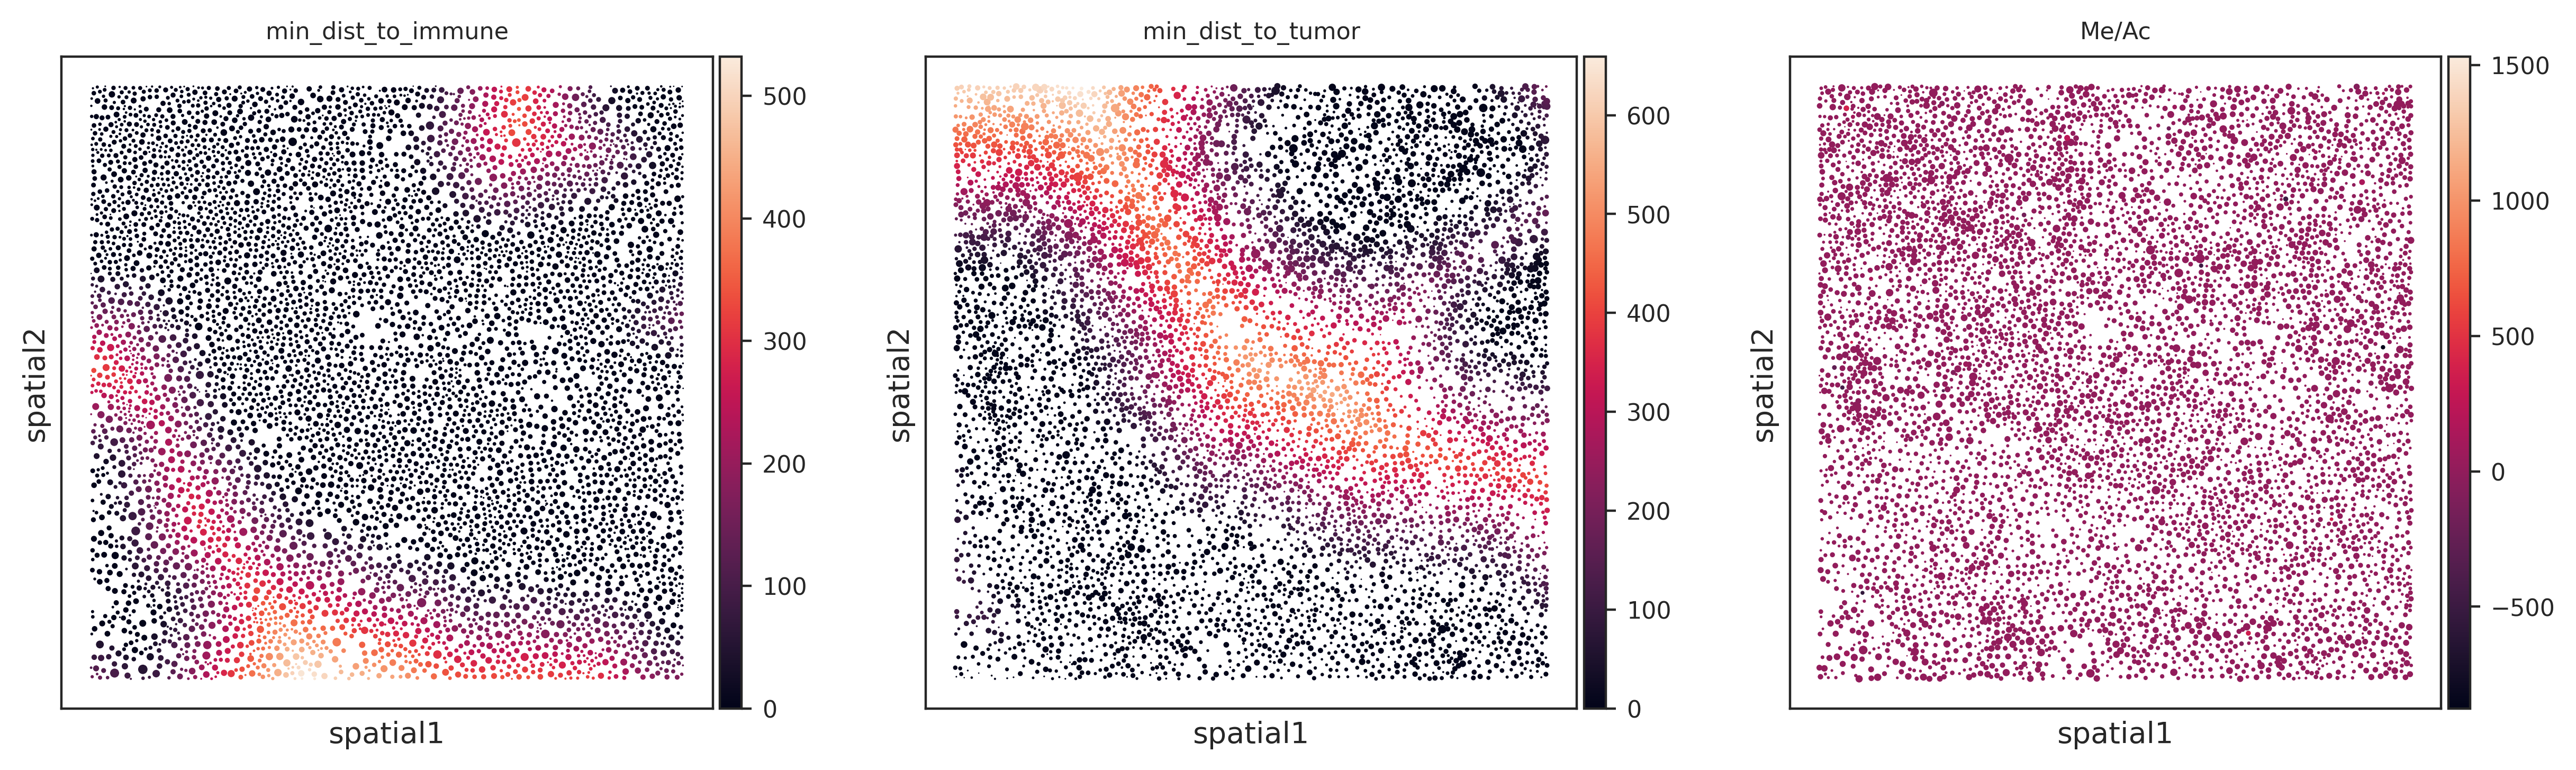

In [11]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor','Me/Ac'],size=adata.obs['cellSize']/50)

# polarize in tumor

In [14]:

# from original paper
boundary_sz_pixel = 100

In [15]:
boundary_array = np.array(adata.obs['leiden_EMD_merge'].copy())
min_dist_to_immune_array = np.array(adata.obs['min_dist_to_immune'].copy())
min_dist_to_tumor_array = np.array(adata.obs['min_dist_to_tumor'].copy())

In [16]:
boundary_array[(boundary_array=='tumor') & (min_dist_to_immune_array<=boundary_sz_pixel)] = 'boundary_tumor'
boundary_array[(boundary_array=='immune') & (min_dist_to_tumor_array<=boundary_sz_pixel)] = 'boundary_immune'

In [17]:
adata.obs['boundary'] = boundary_array

/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'boundary' as categorical


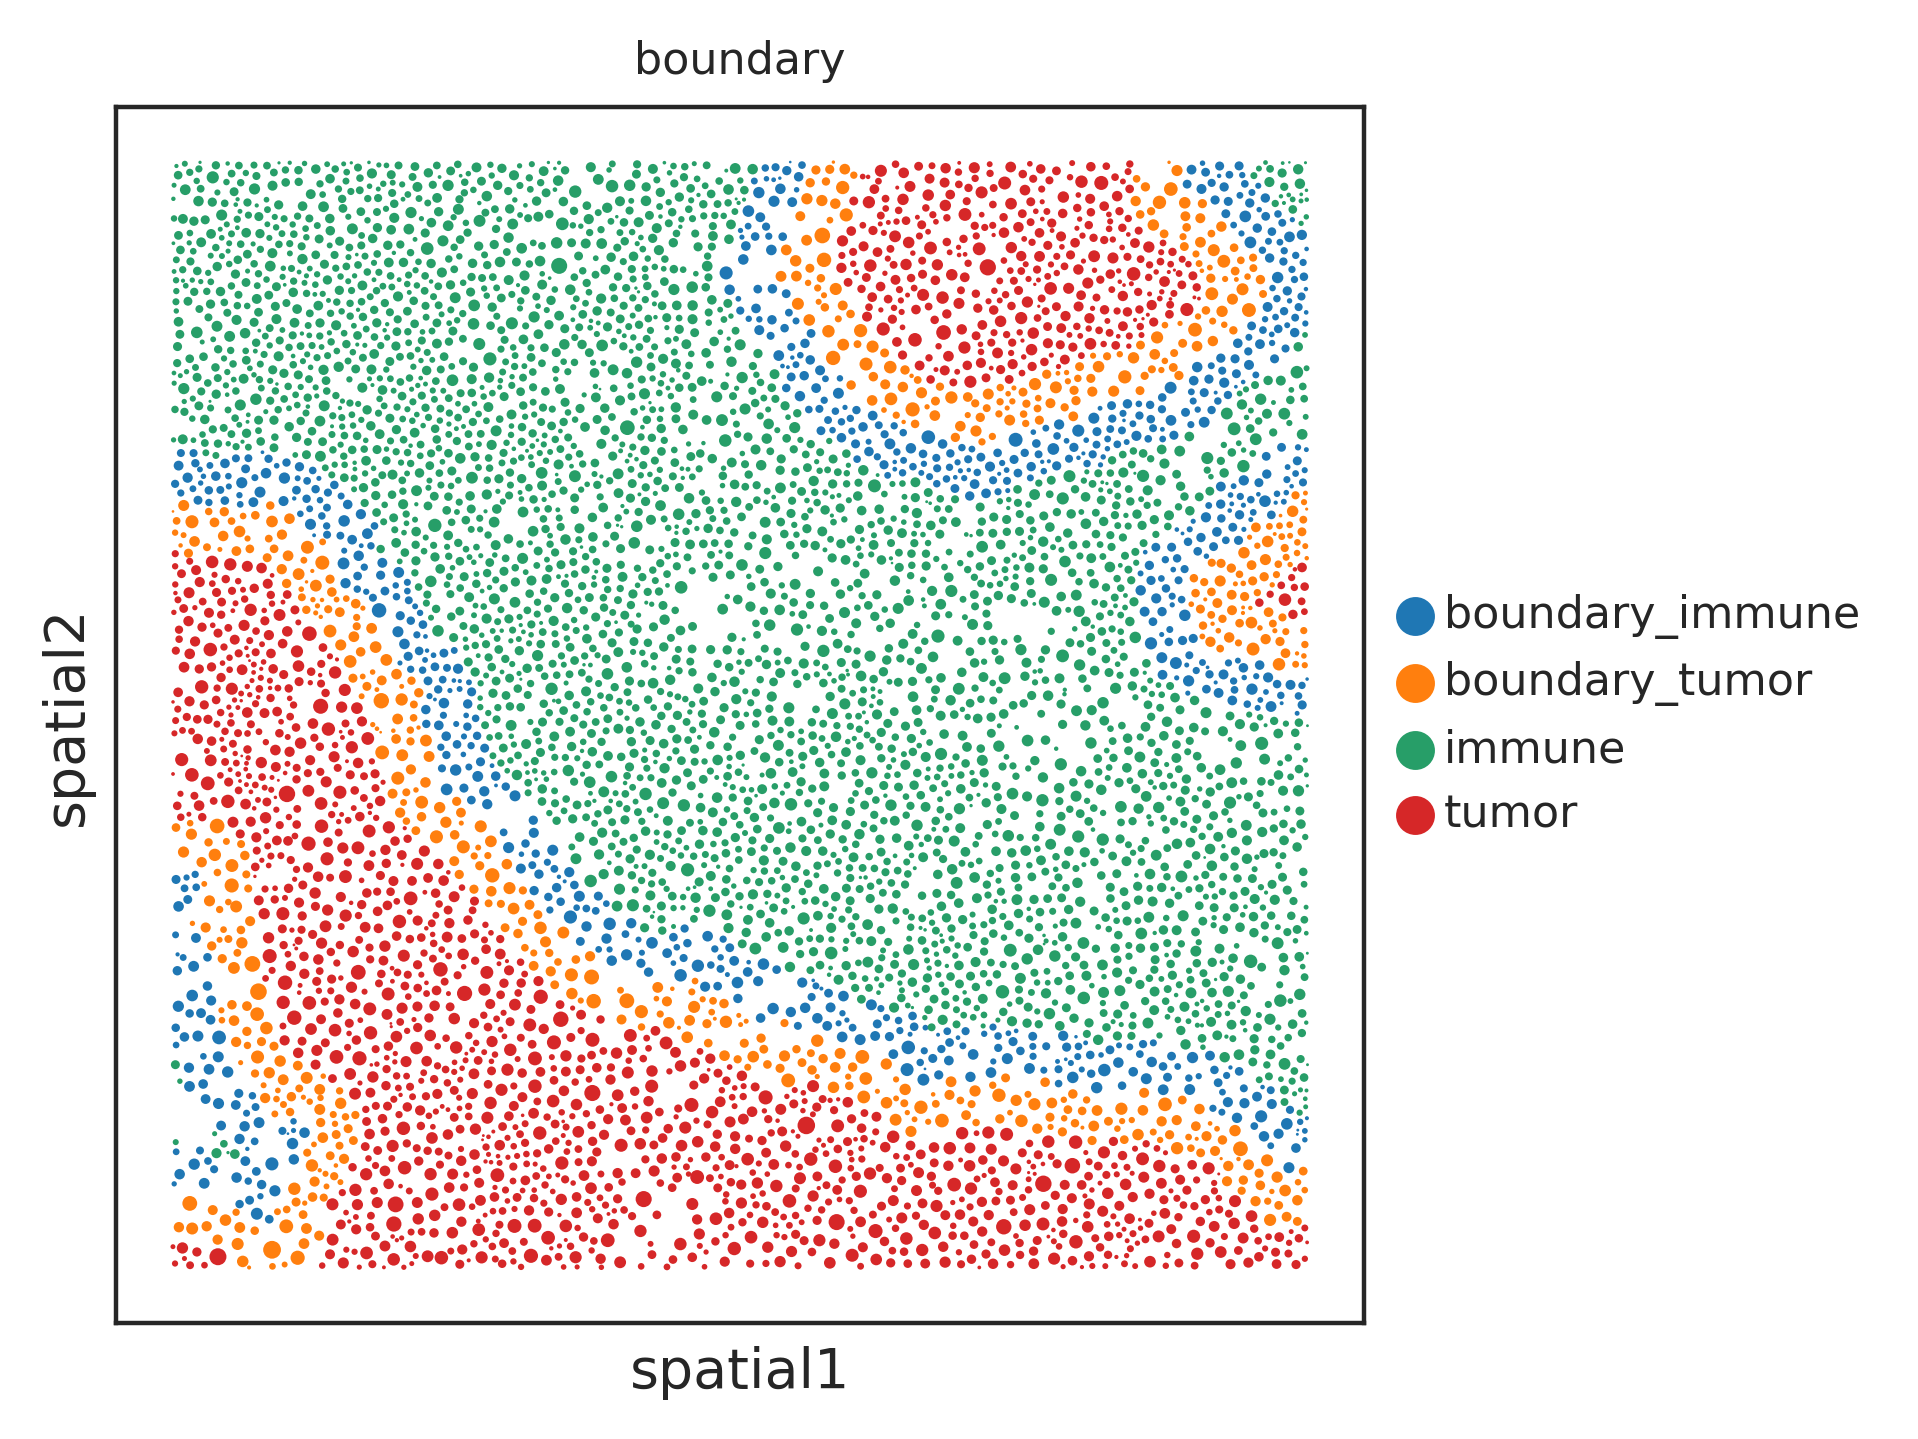

In [18]:
sc.pl.embedding(adata,basis='spatial',color=['boundary'],size=adata.obs['cellSize']/50)

In [27]:

def test_polar(adata,obs,between,protein,var):
    array_0 = np.array(adata[adata.obs[obs]==between[0],protein].X)
    array_1 = np.array(adata[adata.obs[obs]==between[1],protein].X)
    pv = ranksums(array_0,array_1,alternative='two-sided')[1]
    adata.var[var][np.where(adata.var_names==protein)[0]] = pv
    
    
    
    return pv

# porlar to tumor, ranksum

In [47]:
ad_new

AnnData object with n_obs × n_vars = 6643 × 37
    obs: 'SampleID', 'cellLabelInImage', 'cellSize', 'C', 'Na', 'Si', 'P', 'Ca', 'Fe', 'Background', 'B7H3', 'OX40', 'CD163', 'CSF-1R', 'Ta', 'Au', 'tumorYN', 'tumorCluster', 'Group', 'immuneCluster', 'immuneGroup', 'group_name', 'immuneGroup_name', 'all_group_name', 'ME_heter_all_group_name_uniform', 'ME_heter_all_group_name_paga_guided_umap', 'leiden_EMD', 'leiden_EMD_merge', 'min_dist_to_immune', 'min_dist_to_tumor', 'boundary'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'spatial'
    obsp: 'ME_EMD_mat', 'connectivities', 'distances'

In [28]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_tumor','tumor']
var_name = 'sotip_polar_in_tumor'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [29]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_immune','immune']
var_name = 'sotip_polar_in_immune'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [30]:
adata.var

sotip_polar_in_tumor  sotip_polar_in_tumor_bh  \
dsDNA                 5.134562e-01             6.550993e-01   
Vimentin              7.087574e-07             2.185335e-06   
SMA                   1.921887e-01             3.555492e-01   
FoxP3                 4.782450e-01             6.550993e-01   
Lag3                  8.530593e-01             9.564605e-01   
CD4                   6.057806e-11             2.801735e-10   
CD16                  2.223342e-01             3.739257e-01   
CD56                  9.558181e-01             1.000000e+00   
PD1                   6.282676e-01             7.748634e-01   
CD31                  4.713846e-01             6.550993e-01   
PD-L1                 6.983816e-19             5.168024e-18   
EGFR                  1.744595e-08             6.455002e-08   
Ki67                  4.764895e-01             6.550993e-01   
CD209                 9.819769e-01             1.000000e+00   
CD11c                 3.433276e-11             1.814731e-10   
CD138                 6.981529e-01             8.142698e-01   
CD68                  6.459186e-04             1.593266e-03   
CD8                   3.872446e-01             5.970020e-01   
CD3                   1.269747e-04             3.613897e-04   
IDO                   2.153347e-01             3.739257e-01   
Keratin17             1.760632e-49             2.171446e-48   
CD63                  9.792766e-01             1.000000e+00   
CD45RO                5.970055e-07             2.008109e-06   
CD20                  3.628045e-01             5.836421e-01   
p53                   1.000000e+00             1.000000e+00   
Beta catenin          8.300169e-04             1.919414e-03   
HLA-DR                4.913569e-48             4.545051e-47   
CD11b                 4.995219e-01             6.550993e-01   
CD45                  3.589000e-03             7.377388e-03   
H3K9ac                1.238124e-09             5.090065e-09   
Pan-Keratin           1.823567e-04             4.819426e-04   
H3K27me3              1.411621e-01             2.748946e-01   
phospho-S6            2.153293e-16             1.327864e-15   
MPO                   7.042333e-01             8.142698e-01   
Keratin6              7.245791e-57             1.340471e-55   
HLA_Class_1           1.892732e-79             7.003108e-78   
Me/Ac                 1.872889e-03             4.076288e-03   

              sotip_polar_in_immune  sotip_polar_in_immune_bh  
dsDNA                  1.919047e-02              3.550237e-02  
Vimentin               6.608973e-13              3.493314e-12  
SMA                    4.576924e-03              1.058414e-02  
FoxP3                  1.600237e-01              2.467032e-01  
Lag3                   6.015674e-01              7.537937e-01  
CD4                    1.609571e-14              1.191083e-13  
CD16                   1.665599e-02              3.243534e-02  
CD56                   9.874278e-01              9.874278e-01  
PD1                    5.712878e-01              7.537937e-01  
CD31                   1.810008e-05              5.151561e-05  
PD-L1                  2.121991e-02              3.738746e-02  
EGFR                   5.896350e-01              7.537937e-01  
Ki67                   9.787517e-01              9.874278e-01  
CD209                  2.095310e-01              3.101058e-01  
CD11c                  2.017178e-20              2.487853e-19  
CD138                  1.384718e-28              5.123456e-27  
CD68                   7.011662e-08              2.358468e-07  
CD8                    7.237861e-03              1.487782e-02  
CD3                    3.443397e-04              8.493712e-04  
IDO                    5.184504e-03              1.128392e-02  
Keratin17              8.398746e-01              9.416776e-01  
CD63                   6.167528e-01              7.537937e-01  
CD45RO                 5.640793e-23              1.043547e-21  
CD20                   1.216427e-05              3.750650e-05  
p53                

In [24]:
gt_polarized_tumor_all = ['EGFR','Beta catenin','Pan-Keratin','p53','Ki67','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_all = ['CD20','CD209','CD11b','HLA-DR','FoxP3','Ki67','CD56','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']



In [31]:
gt_polarized_tumor_p4 = ['EGFR','Beta catenin','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_p4 = ['CD20','CD209','HLA-DR','FoxP3','PD-L1','IDO','CD45RO','CD4','CD11c','CD68']
gt_polarized_tumor_p9 = ['Me/Ac','PD-L1','HLA-DR']
gt_polarized_immune_p9 = ['CD20','CD11b','HLA-DR','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']

In [34]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_tumor'] = gt_polarized_array
adata.var['gt_polarized_tumor'][adata.var_names.isin(gt_polarized_tumor_p4)] = 1

In [35]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_immune'] = gt_polarized_array
adata.var['gt_polarized_immune'][adata.var_names.isin(gt_polarized_immune_p4)] = 1

In [36]:
adata.write_h5ad('sotip_polar_test_p4.h5ad')